# 0.5 Making dataset

In [1]:
%matplotlib inline

In [2]:
cd /Users/anacriel/plant_seed_classification/

/Users/anacriel/plant_seed_classification


In [43]:
import src.visualization.visualize as vs
import src.features.build_features as bfeatures
import os
import cv2
import pandas as pd
import numpy as np
import mahotas as mt
from src.data.make_dataset import get_images
from matplotlib import pyplot as plt

In [4]:
cd /Users/anacriel/plant_seed_classification/src

/Users/anacriel/plant_seed_classification/src


In [5]:
proc_data_dir = '../data/raw/'
train_image_dir = os.path.join(proc_data_dir, 'train')

In [6]:
Images, Labels = get_images(train_image_dir)

In [7]:
labels = []
mapping = { 'Sugar beet': 0, 'Fat Hen': 1, 'Scentless Mayweed' : 2, 'Charlock' : 3,
           'Small-flowered Cranesbill': 4, 'Maize': 5, 'Shepherds Purse' :6, 'Common wheat': 7,
           'Common Chickweed': 8, 'Cleavers': 9, 'Loose Silky-bent' : 10, 'Black-grass': 11 }
for label in Labels:
    labels.append(mapping[label])

In [24]:
Images = np.reshape(Images,(-1,300,300,3))
Labels = np.array(labels)

array([9, 9, 9, ..., 5, 5, 5])

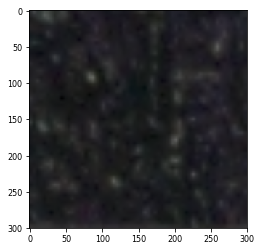

In [78]:
plt.imshow(Images[754]) ##!!!!! damn

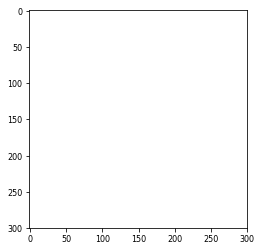

In [79]:
mask = vs.create_mask_for_plant(Images[754])
seg_image = cv2.bitwise_and(Images[754], Images[754], mask=mask)
seg_image = vs.sharpen_image(seg_image)
seg_image[mask == 0] = 255

img = cv2.cvtColor(seg_image, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [89]:
def create_dataset(images, labels):
    features_names = ['label', 'area', 'perimeter', 'physiological_length', \
                      'physiological_width', 'aspect_ratio', 'rectangularity', 'circularity', \
                      'mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g','stddev_b', \
                      'contrast','correlation', 'inverse_difference_moments', 'entropy'
            ]
    df = pd.DataFrame([], columns=features_names)
    for i in range(len(images)):
        #Delete background
        mask = vs.create_mask_for_plant(images[i])
        seg_image = cv2.bitwise_and(images[i], images[i], mask=mask)
        seg_image = vs.sharpen_image(seg_image)
        seg_image[mask == 0] = 255
            
        #Preprocessing
        img = cv2.cvtColor(seg_image, cv2.COLOR_BGR2RGB)
        gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret_otsu, im_bw_otsu = cv2.threshold(gs, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((5, 5), np.uint8)
        closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
        
        #Shape features
        contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        cnt = contours[0]
        M = cv2.moments(cnt)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = 0.0 if h == 0.0 else float(w) / h
        rectangularity = 0.0 if area == 0.0 else  w * h / area
        circularity = 0.0 if area == 0.0 else ((perimeter) ** 2) / area
        
        #Color features
        red_channel = img[:,:,0]
        green_channel = img[:,:,1]
        blue_channel = img[:,:,2]
        blue_channel[blue_channel == 255] = 0
        green_channel[green_channel == 255] = 0
        red_channel[red_channel == 255] = 0
        
        red_mean = np.mean(red_channel)
        green_mean = np.mean(green_channel)
        blue_mean = np.mean(blue_channel)
        
        red_std = np.std(red_channel)
        green_std = np.std(green_channel)
        blue_std = np.std(blue_channel)
        
        #Texture features
        textures = mt.features.haralick(gs)
        ht_mean = textures.mean(axis=0)
        contrast = ht_mean[1]
        correlation = ht_mean[2]
        inverse_diff_moments = ht_mean[4]
        entropy = ht_mean[8]
        
        vector = [labels[i], area,perimeter,w,h,aspect_ratio,rectangularity,circularity,\
                  red_mean,green_mean,blue_mean,red_std,green_std,blue_std,\
                  contrast,correlation,inverse_diff_moments,entropy
                 ]
        
        df_temp = pd.DataFrame([vector],columns=features_names)
        df = df.append(df_temp)
    return df

In [90]:
dataset = create_dataset(Images, Labels)

In [91]:
dataset.head()

,label,area,perimeter,physiological_length,physiological_width,aspect_ratio,rectangularity,circularity,mean_r,mean_g,mean_b,stddev_r,stddev_g,stddev_b,contrast,correlation,inverse_difference_moments,entropy
0,9,4731.5,289.036578,75,88,0.852273,1.394906,17.656587,10.813889,12.858433,6.945078,21.764148,25.679687,14.463592,387.330372,0.970058,0.827078,2.842585
0,9,8901.5,426.717817,125,121,1.033058,1.699152,20.455889,13.619089,16.084000,7.870911,25.215709,29.673654,14.943225,354.426094,0.973122,0.829822,2.902780
0,9,4942.5,341.462983,84,91,0.923077,1.546586,23.590687,10.316633,12.143667,6.440978,23.062125,26.891960,14.631709,300.822603,0.971422,0.865500,2.338985
0,9,9126.5,387.119838,98,132,0.742424,1.417411,16.420508,12.527533,14.733822,7.119733,24.378071,28.472611,14.053283,233.826945,0.981433,0.865447,2.536083
0,9,310.5,77.355339,21,27,0.777778,1.826087,19.271653,15.972422,18.640944,10.102156,25.636130,29.667084,16.636622,350.008474,0.978098,0.796205,3.557184


In [92]:
dataset.to_csv("data/advanced_features.csv")